```{glue:} glued_fig
```

# ✂️ Introduction to image segmentation

This tutorial will give you a practical introduction to image segmentation. We'll aim to produce a segmentation mask that identifies objects of interest in an image. We will attempt to separate the objects from the background. Then, we'll see how to distinguish individual objects. Finally, we'll show how to measure properties (size, shape) of these objects.

```{contents}
:local:
```

## Setup

First, make sure that you are executing this notebook in an environment with all the necessary packages installed. We'll import every function and library that we need in the cell below. We'll use these imports progressively in the notebook.

In [1]:
import ipywidgets
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import skimage.data
from skimage.io import imshow
from skimage.exposure import histogram
from skimage.filters import sobel, threshold_otsu
from skimage.measure import regionprops_table
from skimage.segmentation import watershed
from skimage.color import label2rgb

In [2]:
from myst_nb import glue  # To paste the figure output at the top of the notebook

## Load an image

We will use the `coins` image from `skimage.data` as an example. This image shows several coins outlined against a darker background.

In [3]:
image = skimage.data.coins()

print(f'Loaded image in an array of shape: {image.shape} and data type {image.dtype}')
print(f'Intensity range: [{image.min()} - {image.max()}]')

Loaded image in an array of shape: (303, 384) and data type uint8
Intensity range: [1 - 252]


This is what our image looks like:

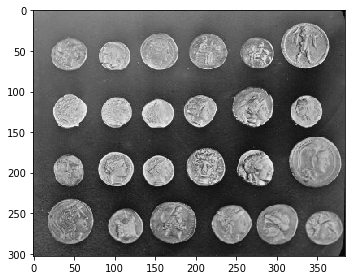

In [4]:
imshow(image)

We can also plot the image histogram:

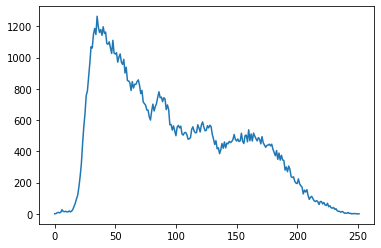

In [5]:
hist, hist_centers = histogram(image)

plt.plot(hist)
plt.show()

## Thresholding

First, we are going to attempt to segment the image by thresholding the graylevel intensities. For this, we select a threshold, and then apply it to the image. All the pixel intensity values above the selected threshold become 1, and the rest 0. This type of image array is known as a **binary mask**.

```{mermaid}
graph LR
    A[Image] --> |Threshold| B[Binary mask]
```

To create a suitable binary mask, the challenge is to find a threshold value that works well for our image (if that is possible), that is, which accurately separates the foreground from the background pixels.

In the cell below, we show you a way of creating an interactive threshold function using `ipywidgets`. Move the slider to see the effect on the segmentation mask.

In [6]:
def segment_image(threshold):
    binary_image = image > threshold
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(binary_image, cmap='gray')
    ax[1].set_title('Segmented Image')
    ax[1].axis('off')
    plt.show()

threshold_slider = ipywidgets.IntSlider(
    value=threshold_otsu(image),
    min=0,
    max=255,
    step=1,
    description='Threshold:',
    continuous_update=True
)

ipywidgets.interactive(segment_image, threshold=threshold_slider)


interactive(children=(IntSlider(value=107, description='Threshold:', max=255), Output()), _dom_classes=('widge…

````{admonition} Automatic thresholding
There are methods to automatically select intensity thresholds based on the image histogram. One of these methods is Otsu thresholding. You can try the following:

```python
from skimage.filters import threshold_otsu
threshold = threshold_otsu(blobs)
binary_blobs = blobs < threshold
```
However, this only selects a good guess for a threshold.
````

It looks like simply thresholding the image leads either to missing significant parts of the coins, or to merging parts of the background with the coins. This is due to the inhomogeneous lighting of the image.

Therefore, we'll try a more advanced segmentation approach.

## Watershed segmentation

The watershed transform floods an image of elevation starting from markers, in order to determine the catchment basins of these markers. Watershed lines separate these catchment basins, and correspond to the desired segmentation.

The choice of the elevation map is critical for good segmentation. Here, we use the Sobel operator for computing the amplitude of the intensity gradient in the original image (the edges):

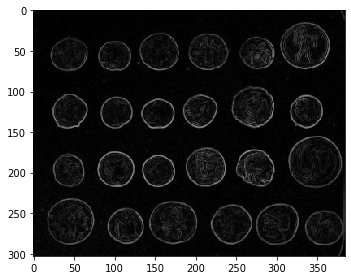

In [7]:
edges = sobel(image)

imshow(edges)

Let us first determine markers of the coins and the background. These markers are pixels that we can label unambiguously as either object or background. Here, the markers are found at the two extreme parts of the histogram of gray values:

In [8]:
markers = np.zeros_like(image)
markers[image < 30] = 1
markers[image > 150] = 2

Let us now compute the watershed transform:

/home/wittwer/miniconda3/envs/field-guide-015/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


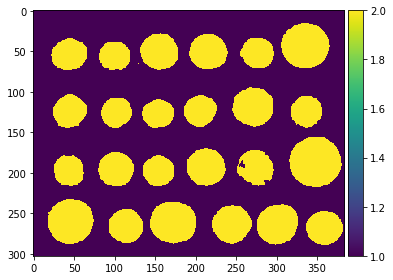

In [9]:
segmentation = watershed(edges, markers)

imshow(segmentation)

With this method, the result is satisfying for all coins. Even if the markers for the background were not well distributed, the barriers in the elevation map were high enough for these markers to flood the entire background.

To further improve the segmentation, we remove a few small holes using the `scipy.ndimage.binary_fill_holes()` function:

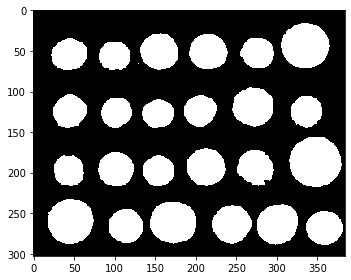

In [10]:
segmentation = ndi.binary_fill_holes(segmentation - 1)

imshow(segmentation)

Our binary mask looks good. The next step is to distinguis the coins from each other, which we can do using an algorithm known as connected components labeling.

## Connected component labeling

Conceptionally, label images are an extension of binary masks. In a label image, all pixels with value 0 correspond to background. Pixels with a value larger than 0 denote that the pixel belongs to an object and identifies that object with the given number. A pixel with value `1` belongs to  first object and pixels with value `2` belongs to a second object and so on. When objects are labeled subsequently, the maximum value in a label mask corresponds to the number of objects in the image.

Let's label all the coins in our binary mask using the `ndi.label` function from Scipy:

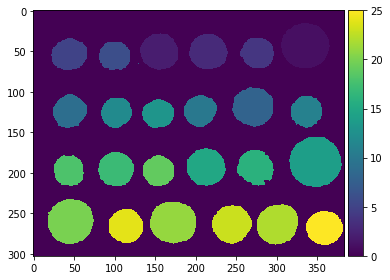

In [11]:
labeled_segmentation, _ = ndi.label(segmentation)

imshow(labeled_segmentation)

This is nice. Now, what if we want to measure some properties of our labeled objects, such as their size?

## Measuring region properties

After segmenting and labeling objects in an image, we can measure properties of these objects. To read out properties from regions, we use the [regionprops_table](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) function from Scikit-image. We read the properties into a [Pandas DataFrame](https://biapol.github.io/Image-data-science-with-Python-and-Napari-EPFL2022/day4a_Tabular_Data/Tabular_Data.html), which is a common asset for data scientists.

In [12]:
properties = regionprops_table(labeled_segmentation, intensity_image=image, properties=['label', 'area', 'centroid', 'bbox', 'eccentricity', 'intensity_mean'])

df = pd.DataFrame(properties)

df.head()

label    area  centroid-0  centroid-1  bbox-0  bbox-1  bbox-2  bbox-3  \
0      1  2604.0   43.536866  334.656682      16     305      72     365   
1      2  1653.0   50.774955  155.258923      28     132      74     179   
2      3  1622.0   51.098644  215.235512      30     192      73     240   
3      4  1225.0   52.389388  276.126531      34     255      72     297   
4      5  1355.0   54.390406   44.177122      35      22      74      67   

   eccentricity  intensity_mean  
0      0.332340      156.808372  
1      0.294055      169.370841  
2      0.383282      157.607275  
3      0.388527      154.203265  
4      0.510381      167.821402

From there, we can study individual measurements or compute statistics on the whole dataset of detected objects. For example:

In [13]:
df.describe()

label         area  centroid-0  centroid-1      bbox-0      bbox-1  \
count  25.000000    25.000000   25.000000   25.000000   25.000000   25.000000   
mean   13.000000  1557.800000  154.499355  189.403899  133.880000  167.600000   
std     7.359801   625.452303   81.205187  102.941702   79.477104  101.027224   
min     1.000000     2.000000   43.536866   43.690391   16.000000   18.000000   
25%     7.000000  1175.000000   65.000000  102.291629   65.000000   84.000000   
50%    13.000000  1471.000000  127.212628  172.303404  110.000000  144.000000   
75%    19.000000  1765.000000  197.743056  273.524733  179.000000  251.000000   
max    25.000000  3141.000000  267.864646  358.171044  248.000000  336.000000   

           bbox-2      bbox-3  eccentricity  intensity_mean  
count   25.000000   25.000000     25.000000       25.000000  
mean   176.200000  212.120000      0.369585      162.924813  
std     83.442595  104.973139      0.155395       16.668389  
min     66.000000   63.000000      0.203215      130.988511  
25%     74.000000  124.000000      0.263170      153.616162  
50%    145.000000  201.000000      0.341121      159.189983  
75%    218.000000  297.000000      0.419496      171.959471  
max    289.000000  382.000000      1.000000      194.683380

To save the dataframe to disk conveniently, you could run `dataframe.to_csv("blobs_analysis.csv")`.

## Displaying a figure

We use the `label2rgb` function from Scikit-image to display the segmentation overlaid on the original image.

In [63]:
fig, ax = plt.subplots(figsize=(12, 6))
rgb_composite = label2rgb(labeled_segmentation, image=image, bg_label=0)
ax.imshow(rgb_composite)
plt.axis('off')
plt.show()

In [66]:
# Show the figure at the top of the notebook
glue('glued_fig', fig, display=False);